# Data extraction and cleaning for OpenDengue
### Author: Hailey Robertson
### Date: 2024-09-24
### Citations:
- Clarke J, Lim A, Gupte P, Pigott DM, van Panhuis WG, Brady OJ. A global dataset of publicly available dengue case count data. Sci Data. 2024 Mar 14;11(1):296.
- Clarke J, Lim A, Gupte P, Pigott DM, van Panhuis WG, Brady OJ. OpenDengue: data from the OpenDengue database. Version [1.2]. figshare; 2023. Available from: https://doi.org/10.6084/m9.figshare.24259573.


### DONE 
- find NAs at adm2 and adm1 compared to adm0 (8% missing adm1, 44% missing adm2)
- zero-filling – zeroes were most likely previously NAs, but not necessarily 
- dates to dates
- floats to floats
- match on iso3
- observed reporting period differences (1 year, 30 days, 1 week)
- combined place column + geocode


## Imports and constants

In [1]:
# Imports
import requests
import pandas as pd
from datetime import datetime
import os
import numpy as np
import geopandas as gpd
import country_converter as coco
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import font_manager
import seaborn as sns
from brokenaxes import brokenaxes
from geopy.geocoders import Nominatim
import pickle
import time
from dotenv import load_dotenv

load_dotenv()

False

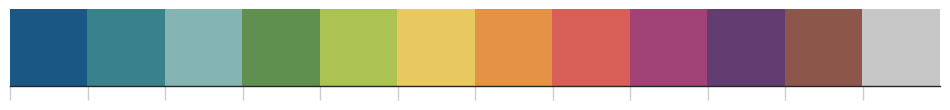

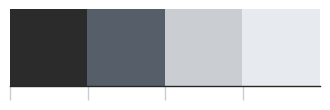

In [184]:
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71', '#8c564b', '#c7c7c7']
sns.palplot(sns.color_palette(colors))

# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

# Define constants
figure_size = (20,6)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 8

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["ytick.minor.pad"] = 0
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 0.1
plt.rcParams["ytick.minor.width"] = 0.1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 8


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.5

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125



# Set axis labels
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelcolor'] = chart[1]

## Cleaning

In [3]:
# Get data from master repo, reset index to access adm_0_name
url = 'https://raw.githubusercontent.com/OpenDengue/master-repo/refs/heads/main/data/raw_data/masterDB_V1.2.csv'
df = pd.read_csv(url, index_col=0, encoding='latin-1').reset_index()

# Convert unstandardized country names into iso3 codes
df["adm_0_iso3"] = coco.convert(names=df["adm_0_name"],to='ISO3', not_found="missing")

# Convert all date columns to datetime
date_cols = ['calendar_start_date', 'calendar_end_date']
df[date_cols] = df[date_cols].apply(pd.to_datetime)

df.head()

,adm_0_name,adm_0_code,adm_1_name,adm_1_code,adm_2_name,adm_2_code,calendar_start_date,calendar_end_date,dengue_total,case_definition_standardised,UUID,adm_0_iso3
0,Argentina,12.0,Salta,445.0,Oran,4781.0,2019-07-21,2019-07-27,2.0,Total,MOH-ARG-2019-Y01-00,ARG
1,Argentina,12.0,Misiones,442.0,Iguazu,4728.0,2019-09-01,2019-09-07,1.0,Total,MOH-ARG-2019-Y01-00,ARG
2,Argentina,12.0,Salta,445.0,Grl. Jose De San Martin,4773.0,2019-07-14,2019-07-20,1.0,Total,MOH-ARG-2019-Y01-00,ARG
3,Argentina,12.0,Jujuy,438.0,Ledesma,4649.0,2019-07-14,2019-07-20,1.0,Total,MOH-ARG-2019-Y01-00,ARG
4,Argentina,12.0,Salta,445.0,Grl. Jose De San Martin,4773.0,2019-06-30,2019-07-06,3.0,Total,MOH-ARG-2019-Y01-00,ARG


In [4]:
# Check for missing iso3 (should be empty)
missing_rows = df[df["adm_0_iso3"] == "missing"]
if len(missing_rows) == 0:
    print("No missing values!")
else:
    print(missing_rows)

country_dict = dict(zip(df['adm_0_iso3'], df['adm_0_name']))

# Group by 'adm_0_iso3' and filter groups with more than one unique 'adm_0_name'
duplicates = df.groupby('adm_0_iso3').filter(lambda x: x['adm_0_name'].nunique() > 1)

# Get the iso3 codes that have more than one country name
problematic_iso3_codes = duplicates['adm_0_iso3'].unique()

print("Unique ISO3 codes:", len(country_dict))
print("ISO3 codes with multiple names:", problematic_iso3_codes)

No missing values!
Unique ISO3 codes: 102
ISO3 codes with multiple names: ['DOM' 'PER' 'USA' 'VCT' 'KNA' 'ATG' 'TCA' 'TTO' 'MYS' 'FSM' 'MNP' 'PCN'
 'VNM' 'WLF']


In [5]:
# World geometry shapefile, devastating that get_path("naturalearth_lowres") was deprecated 
world = gpd.read_file("../data/ne_110m_admin_0_countries")
# print(world.columns.tolist())
world = world.rename(columns={"ADM0_A3":"adm_0_iso3",
                              "ADMIN":"adm_0_name",
                              "REGION_UN":"region_un",
                              "geometry":"adm_0_geometry"})
cols = ['adm_0_iso3','adm_0_name','region_un','adm_0_geometry']
world = world[cols]
world = world.sort_values(by="adm_0_name")

# Fix known issues in geopandas
world.loc[world['adm_0_name'] == 'France', 'adm_0_iso3'] = 'FRA'
world.loc[world['adm_0_name'] == 'Norway', 'adm_0_iso3'] = 'NOR'
world.loc[world['adm_0_name'] == 'Somaliland', 'adm_0_iso3'] = 'SOM'
world.loc[world['adm_0_name'] == 'Kosovo', 'adm_0_iso3'] = 'RKS'

In [6]:
# Merge geometry, keeping nulls
open_dengue = pd.merge(df,world,on='adm_0_iso3',how='outer')

# Fill adm_0_name_x with values from adm_0_name_y if it is empty
open_dengue['adm_0_name'] = open_dengue['adm_0_name_x'].where(open_dengue['adm_0_name_x'].notna() & (open_dengue['adm_0_name_x'] != ''), open_dengue['adm_0_name_y'])

# Drop the original _x and _y columns
open_dengue = open_dengue.drop(columns=['adm_0_name_x', 'adm_0_name_y'])

# Move adm_0_name and adm_0_iso3 to the front
columns = ['adm_0_name', 'adm_0_iso3'] + [col for col in open_dengue.columns if col not in ['adm_0_name', 'adm_0_iso3']]
open_dengue = open_dengue[columns]

print("Number of ISO3 codes: ", len(open_dengue.adm_0_iso3.unique()))
print("regions: ", open_dengue.region_un.unique())

Number of ISO3 codes:  220
regions:  [nan 'Asia' 'Africa' 'Europe' 'Americas' 'Antarctica' 'Oceania']


In [7]:
# Check UN region
missing_un_region = open_dengue[open_dengue['region_un'].isna()]
print(missing_un_region.adm_0_name.unique())
# Fill with 'Other' for now
open_dengue['region_un'] = open_dengue['region_un'].fillna("Other")

['Aruba' 'Anguilla' 'American Samoa' 'Antigua and Barbuda'
 'Antigua And Barbuda' 'Bonaire, Saint Eustatius and Saba'
 'Saint Barthelemy' 'Bermuda' 'Barbados' 'Cook Islands' 'Curacao'
 'Cayman Islands' 'Dominica' 'Micronesia (Federated States Of)' 'FSM'
 'Micronesia (Federated States of)' 'Guadeloupe' 'Grenada' 'French Guiana'
 'Guam' 'Hong Kong' 'Kiribati' 'Saint Kitts and Nevis'
 'Saint Kitts And Nevis' 'Saint Lucia' 'Macau' 'Saint Martin' 'Maldives'
 'Marshall Islands' 'Northern Mariana Islands' 'N Mariana Is' 'Montserrat'
 'Martinique' 'Niue' 'Nauru' 'Pitcairn' 'Pitcairn Islands' 'Palau'
 'French Polynesia' 'Singapore' 'Sint Maarten' 'Turks and Caicos Islands'
 'Turks And Caicos Islands' 'Tokelau' 'Tonga' 'Tuvalu'
 'Saint Vincent and the Grenadines' 'Saint Vincent And The Grenadines'
 'Virgin Islands (UK)' 'Virgin Islands (US)' 'Wallis And Futuna'
 'Wallis and Futuna' 'Wallis & Futuna' 'Samoa']


In [8]:
# Extract year from calendar_start_date
open_dengue['year'] = open_dengue['calendar_start_date'].dt.year

#  Not all periods are the same length – some places report every year, some every month, some every week
open_dengue["date_diff"] = (open_dengue["calendar_end_date"] - open_dengue["calendar_start_date"]).dt.days

# Find geo resolution and combine places
def highest_geo_resolution(row):
    if pd.notna(row['adm_2_name']) and row['adm_2_name'] != '':
        return 'adm_2'
    elif pd.notna(row['adm_1_name']) and row['adm_1_name'] != '':
        return 'adm_1'
    else:
        return 'adm_0'

open_dengue['geo_resolution'] = open_dengue.apply(highest_geo_resolution, axis=1)

open_dengue['combined_place'] = open_dengue[['adm_2_name', 'adm_1_name', 'adm_0_name']].apply(
    lambda x: ', '.join([str(place) for place in x if pd.notna(place) and place != '']), axis=1)

## Export

In [10]:
# # Save the DataFrame as a CSV file – too big to commit!
# open_dengue.to_csv("../data/open_dengue_v1_2.csv", index=False)

## Analysis

### Temporal and geographic resolution

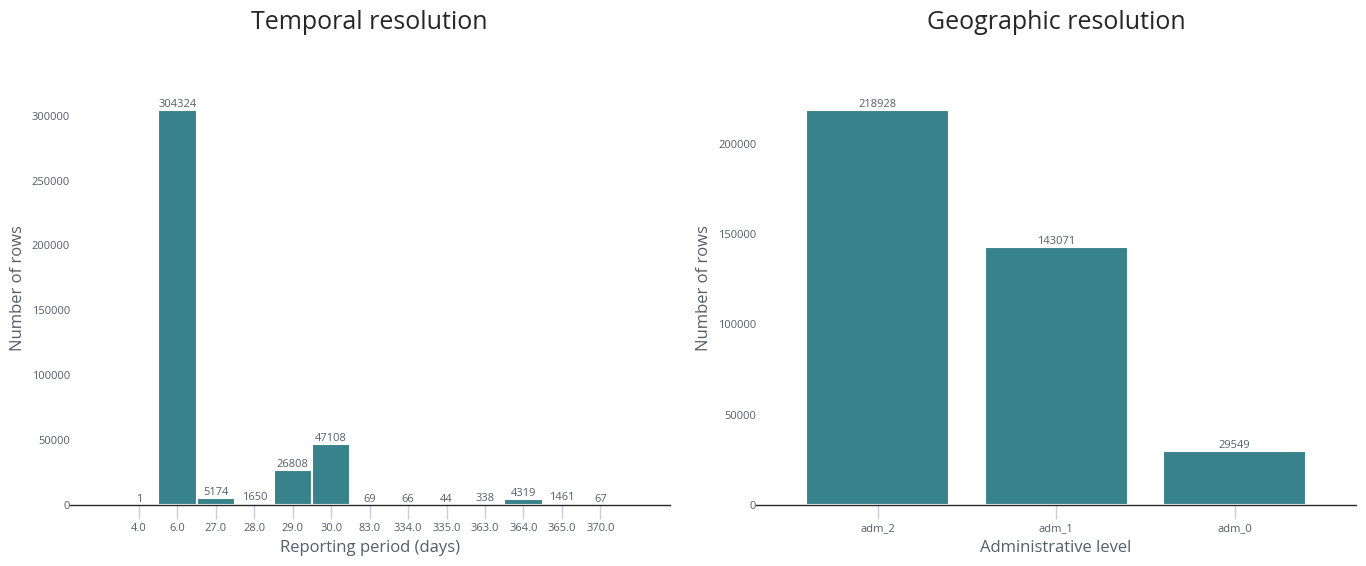

In [11]:
# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Number of rows by reporting period

trying = pd.Categorical(open_dengue['date_diff'])
reporting_period_counts = pd.Series(trying).value_counts().sort_index()
# reporting_period_counts = open_dengue['date_diff'].value_counts().sort_index()

bars = ax1.bar(reporting_period_counts.index.astype(str), reporting_period_counts.values, color = colors[1], width = 1)

# Adding height labels above each bar
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color=chart[1])


ax1.set_title('Temporal resolution')
ax1.set_xlabel('Reporting period (days)')
ax1.set_ylabel('Number of rows')

# Second subplot: Number of rows by geographic resolution
geo_resolution_counts = open_dengue['geo_resolution'].value_counts()
bars2 = ax2.bar(geo_resolution_counts.index, geo_resolution_counts.values, color=colors[1])

for bar2 in bars2:
    height = bar2.get_height()
    ax2.text(bar2.get_x() + bar2.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color=chart[1])

ax2.set_title('Geographic resolution')
ax2.set_xlabel('Administrative level')
ax2.set_ylabel('Number of rows')

# Display the plots
plt.tight_layout()
plt.show()

### Data coverage over time
- up until what year are open dengue data reliable? e.g., is 2020 complete?

#### Roll up to country level and year

In [41]:
# Fill the years so that ISO3s stay
years = pd.Series(range(int(1950), int(open_dengue['year'].max()) + 1))
unique_iso3 = open_dengue['adm_0_iso3'].unique()

all_combinations = pd.MultiIndex.from_product([unique_iso3, years], names=['adm_0_iso3', 'year']).to_frame(index=False)

open_dengue_rollup = all_combinations.merge(open_dengue, on=['adm_0_iso3', 'year'], how='outer')

# List of columns to fill
columns_to_fill = ['adm_0_name', 'region_un', 'adm_0_geometry', 'geo_resolution', 'combined_place']

# Fill NaN values for multiple columns
open_dengue_rollup[columns_to_fill] = (
    open_dengue_rollup
    .groupby('adm_0_iso3')[columns_to_fill]
    .transform(lambda x: x.ffill().bfill())
)

open_dengue_rollup = open_dengue_rollup.dropna(subset=['year'])

open_dengue_rollup.head()

,adm_0_iso3,year,adm_0_name,adm_0_code,adm_1_name,adm_1_code,adm_2_name,adm_2_code,calendar_start_date,calendar_end_date,dengue_total,case_definition_standardised,UUID,region_un,adm_0_geometry,date_diff,geo_resolution,combined_place
0,ABW,1950.0,Aruba,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Other,None,NaN,adm_0,Aruba
1,ABW,1951.0,Aruba,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Other,None,NaN,adm_0,Aruba
2,ABW,1952.0,Aruba,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Other,None,NaN,adm_0,Aruba
3,ABW,1953.0,Aruba,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Other,None,NaN,adm_0,Aruba
4,ABW,1954.0,Aruba,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Other,None,NaN,adm_0,Aruba


In [221]:
# Merge with population size per year
pop = pd.read_csv("../data/WPP2022_Demographic_Indicators_Medium.csv", dtype={'Time': float,'TPopulation1July':float}, low_memory=False)
columns = ['ISO3_code','Time','TPopulation1July']
pop = pop[columns]

dengue_pop = open_dengue_rollup.merge(pop,left_on=['adm_0_iso3','year'],right_on=['ISO3_code','Time'],how='outer')
dengue_pop.drop(columns[:-1],axis=1,inplace=True)
dengue_pop = dengue_pop.dropna(subset=['adm_0_iso3'])

dengue_pop = dengue_pop.groupby(['adm_0_iso3', 'year','region_un','TPopulation1July']).agg({
    'dengue_total': 'sum'
}).reset_index()

# Calculate incidence
dengue_pop['TPopulation1July'] = dengue_pop['TPopulation1July'] * 1000
dengue_pop['incidence'] = dengue_pop['dengue_total'] / dengue_pop['TPopulation1July']
dengue_pop['incidence_per_100k'] = dengue_pop['incidence'] * 100000
dengue_pop['year'] = dengue_pop['year'].astype(int)

dengue_pop.sort_values(by="incidence", ascending=False)
dengue_pop.head()

,adm_0_iso3,year,region_un,TPopulation1July,dengue_total,incidence,incidence_per_100k
0,ABW,1950,Other,38798.0,0.0,0.0,0.0
1,ABW,1951,Other,40231.0,0.0,0.0,0.0
2,ABW,1952,Other,41758.0,0.0,0.0,0.0
3,ABW,1953,Other,43305.0,0.0,0.0,0.0
4,ABW,1954,Other,44869.0,0.0,0.0,0.0


#### Regional mapping - UN member states

In [222]:
# Creating the dictionary with ISO3 codes as keys and regions as values - this is UN member states by region
countries = {
    "DZA": "African States", "SWZ": "African States", "NAM": "African States",
    "AGO": "African States", "ETH": "African States", "NER": "African States",
    "BEN": "African States", "GAB": "African States", "NGA": "African States",
    "BWA": "African States", "GMB": "African States", "RWA": "African States",
    "BFA": "African States", "GHA": "African States", "STP": "African States",
    "BDI": "African States", "GIN": "African States", "SEN": "African States",
    "CPV": "African States", "GNB": "African States", "SYC": "African States",
    "CMR": "African States", "KEN": "African States", "SLE": "African States",
    "CAF": "African States", "LSO": "African States", "SOM": "African States",
    "TCD": "African States", "LBR": "African States", "ZAF": "African States",
    "COM": "African States", "LBY": "African States", "SSD": "African States",
    "COG": "African States", "MDG": "African States", "SDN": "African States",
    "CIV": "African States", "MWI": "African States", "TGO": "African States",
    "COD": "African States", "MLI": "African States", "TUN": "African States",
    "DJI": "African States", "MRT": "African States", "UGA": "African States",
    "EGY": "African States", "MUS": "African States", "TZA": "African States",
    "GNQ": "African States", "MAR": "African States", "ZMB": "African States",
    "ERI": "African States", "MOZ": "African States", "ZWE": "African States",
    
    "AFG": "Asia-Pacific States", "KGZ": "Asia-Pacific States", "WSM": "Asia-Pacific States",
    "BHR": "Asia-Pacific States", "LAO": "Asia-Pacific States", "SAU": "Asia-Pacific States",
    "BGD": "Asia-Pacific States", "LBN": "Asia-Pacific States", "SGP": "Asia-Pacific States",
    "BTN": "Asia-Pacific States", "MYS": "Asia-Pacific States", "SLB": "Asia-Pacific States",
    "BRN": "Asia-Pacific States", "MDV": "Asia-Pacific States", "LKA": "Asia-Pacific States",
    "KHM": "Asia-Pacific States", "MHL": "Asia-Pacific States", "SYR": "Asia-Pacific States",
    "CHN": "Asia-Pacific States", "FSM": "Asia-Pacific States", "TKM": "Asia-Pacific States",
    "CYP": "Asia-Pacific States", "MNG": "Asia-Pacific States", "THA": "Asia-Pacific States",
    "PRK": "Asia-Pacific States", "MMR": "Asia-Pacific States", "TLS": "Asia-Pacific States",
    "FJI": "Asia-Pacific States", "NRU": "Asia-Pacific States", "TON": "Asia-Pacific States",
    "IND": "Asia-Pacific States", "NPL": "Asia-Pacific States", "TUR": "Asia-Pacific States",
    "IDN": "Asia-Pacific States", "OMN": "Asia-Pacific States", "TKM": "Asia-Pacific States",
    "IRN": "Asia-Pacific States", "PAK": "Asia-Pacific States", "TUV": "Asia-Pacific States",
    "IRQ": "Asia-Pacific States", "PLW": "Asia-Pacific States", "ARE": "Asia-Pacific States",
    "JPN": "Asia-Pacific States", "PNG": "Asia-Pacific States", "UZB": "Asia-Pacific States",
    "JOR": "Asia-Pacific States", "PHL": "Asia-Pacific States", "VUT": "Asia-Pacific States",
    "KAZ": "Asia-Pacific States", "QAT": "Asia-Pacific States", "VNM": "Asia-Pacific States",
    "KIR": "Asia-Pacific States", "KOR": "Asia-Pacific States", "YEM": "Asia-Pacific States",
    "KWT": "Asia-Pacific States",
    
    "ALB": "Eastern European States", "EST": "Eastern European States", "MDA": "Eastern European States",
    "ARM": "Eastern European States", "GEO": "Eastern European States", "ROU": "Eastern European States",
    "AZE": "Eastern European States", "HUN": "Eastern European States", "RUS": "Eastern European States",
    "BLR": "Eastern European States", "LVA": "Eastern European States", "SRB": "Eastern European States",
    "BIH": "Eastern European States", "LTU": "Eastern European States", "SVK": "Eastern European States",
    "BGR": "Eastern European States", "MNE": "Eastern European States", "SVN": "Eastern European States",
    "HRV": "Eastern European States", "MKD": "Eastern European States", "UKR": "Eastern European States",
    "CZE": "Eastern European States", "POL": "Eastern European States",
    
    "ATG": "Latin American and Caribbean States", "DMA": "Latin American and Caribbean States", "NIC": "Latin American and Caribbean States",
    "ARG": "Latin American and Caribbean States", "DOM": "Latin American and Caribbean States", "PAN": "Latin American and Caribbean States",
    "BHS": "Latin American and Caribbean States", "ECU": "Latin American and Caribbean States", "PRY": "Latin American and Caribbean States",
    "BRB": "Latin American and Caribbean States", "SLV": "Latin American and Caribbean States", "PER": "Latin American and Caribbean States",
    "BLZ": "Latin American and Caribbean States", "GRD": "Latin American and Caribbean States", "KNA": "Latin American and Caribbean States",
    "BOL": "Latin American and Caribbean States", "GTM": "Latin American and Caribbean States", "LCA": "Latin American and Caribbean States",
    "BRA": "Latin American and Caribbean States", "GUY": "Latin American and Caribbean States", "VCT": "Latin American and Caribbean States",
    "CHL": "Latin American and Caribbean States", "HTI": "Latin American and Caribbean States", "SUR": "Latin American and Caribbean States",
    "COL": "Latin American and Caribbean States", "HND": "Latin American and Caribbean States", "TTO": "Latin American and Caribbean States",
    "CRI": "Latin American and Caribbean States", "JAM": "Latin American and Caribbean States", "URY": "Latin American and Caribbean States",
    "CUB": "Latin American and Caribbean States", "MEX": "Latin American and Caribbean States", "VEN": "Latin American and Caribbean States",
    
    "AND": "Western European and other States", "ISL": "Western European and other States", "NOR": "Western European and other States",
    "AUS": "Western European and other States", "IRL": "Western European and other States", "PRT": "Western European and other States",
    "AUT": "Western European and other States", "ISR": "Western European and other States", "SMR": "Western European and other States",
    "BEL": "Western European and other States", "ITA": "Western European and other States", "ESP": "Western European and other States",
    "CAN": "Western European and other States", "LIE": "Western European and other States", "SWE": "Western European and other States",
    "DNK": "Western European and other States", "LUX": "Western European and other States", "CHE": "Western European and other States",
    "FIN": "Western European and other States", "MLT": "Western European and other States", "TUR": "Western European and other States",
    "FRA": "Western European and other States", "MCO": "Western European and other States", "GBR": "Western European and other States",
    "DEU": "Western European and other States", "NLD": "Western European and other States", "USA": "Western European and other States",
    "GRC": "Western European and other States", "NZL": "Western European and other States",
}

# Updating the 'region_un' column based on the iso3_code
dengue_pop['region_un'] = dengue_pop['adm_0_iso3'].map(countries).fillna("Other")

dengue_pop.head()

,adm_0_iso3,year,region_un,TPopulation1July,dengue_total,incidence,incidence_per_100k
0,ABW,1950,Other,38798.0,0.0,0.0,0.0
1,ABW,1951,Other,40231.0,0.0,0.0,0.0
2,ABW,1952,Other,41758.0,0.0,0.0,0.0
3,ABW,1953,Other,43305.0,0.0,0.0,0.0
4,ABW,1954,Other,44869.0,0.0,0.0,0.0


#### Plot - any coverage

In [ ]:
heatmap_data = dengue_pop.pivot(index='adm_0_iso3', columns='year', values='incidence').fillna(0)

binary_heatmap_data = np.where(heatmap_data == 0, 0, 1)

binary_heatmap_data = pd.DataFrame(binary_heatmap_data, index=dengue_pop['adm_0_iso3'].unique(), columns=dengue_pop['year'].unique())

binary_heatmap_data = binary_heatmap_data.sort_index()

binary_heatmap_data

# Plot

fig, ax = plt.subplots(figsize=(20, 45))  # Adjust size as needed

custom_colors = ["white", colors[1]]


# Plot the heatmap
im = sns.heatmap(data=binary_heatmap_data, cmap=custom_colors, annot=False, fmt='g', linewidths=0.5, ax=ax, vmin=0, vmax=1, cbar=False)

# Set tick labels and axis labels
ax.set_xlabel('Year')
ax.set_ylabel('Country')
ax.set_title("Data Coverage Over Time",loc='left')

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=30)
plt.setp(ax.get_xticklabels(), rotation=90)

ax.tick_params(axis='y', pad=10, width=30, labelsize=10)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set title and show the plot
plt.tight_layout()
# filename = f"../output/figures/open_dengue_coverage_1950-2023_all.png"  # Replace spaces with underscores for safe filenames
# plt.savefig(filename, format='png', dpi=300)
plt.close()

#### Plot - regional coverage

In [ ]:
# Get unique regions
regions = dengue_pop['region_un'].unique()

# Custom color settings
custom_colors = ["white", colors[1]]  # Example colors (adjust as needed)

# Loop through each region and create an individual plot
for region in regions:
    # Filter the heatmap data by region
    region_data = dengue_pop[dengue_pop['region_un'] == region].pivot(index='adm_0_iso3', columns='year', values='incidence').fillna(0)
    binary_region_data = np.where(region_data == 0, 0, 1)
    binary_region_data = pd.DataFrame(binary_region_data, index=region_data.index, columns=region_data.columns)    
    
    # Create a new figure for each region
    plt.figure(figsize=(10, 6))
    
    # Plot the heatmap
    sns.heatmap(data=binary_region_data, cmap=custom_colors, annot=False, fmt='g', linewidths=0.5, vmin=0, vmax=1, cbar=False)
    
    # Set labels and title
    plt.title(f"Data Coverage Over Time - {region}", loc='left')
    plt.ylabel('Country')
    plt.xlabel('Year')
    
    # Customize tick parameters for readability
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    # Adjust layout for better spacing
    plt.tight_layout()

    # # Save each plot with a unique filename based on the region
    # filename = f"../output/figures/open_dengue_coverage_1950-2023_{region.replace(' ', '_')}.png"  # Replace spaces with underscores for safe filenames
    # plt.savefig(filename, format='png', dpi=300)
    
    # Close the plot to free up memory
    plt.close()

### Incidence over time

#### Plot - regional (all countries)

In [229]:
# Define a custom colormap that uses white for 0 and rocket_r for >0
rocket_r_cmap = sns.color_palette("rocket_r", as_cmap=True)
custom_cmap = ListedColormap(["white"] + list(rocket_r_cmap(np.linspace(0.01, 1, 256))))

# Get unique regions
regions = dengue_pop['region_un'].unique()

# Loop through each region and create an individual plot
for region in regions:
    # Filter the heatmap data by region
    region_data = dengue_pop[dengue_pop['region_un'] == region].pivot(index='adm_0_iso3', columns='year', values='incidence_per_100k').fillna(0)
    heatmap_region_data = pd.DataFrame(region_data, index=region_data.index, columns=region_data.columns)
    
    # Create a new figure for each region
    plt.figure(figsize=(14, 14))
    
    # Plot the heatmap with the custom color map
    sns.heatmap(
        data=heatmap_region_data,
        cmap=custom_cmap,
        annot=False,
        fmt='g',
        linewidths=0.5,
        vmin=0,
        vmax=1000,  
        cbar=True,
        cbar_kws={'orientation': 'horizontal', 'pad': 0.07, 'label':'Incidence rate per 100,000'}
    )
    
    # Set labels and title
    plt.title(f"Annual incidence (per 100,000)- {region}", loc='left')
    plt.ylabel('Country')
    plt.xlabel('Year')
    
    # Customize tick parameters for readability
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    # Save each plot with a unique filename based on the region
    filename = f"../output/figures/open_dengue_incidence_1950-2023_{region.replace(' ', '_')}.png"  # Replace spaces with underscores for safe filenames
    plt.savefig(filename, format='png', dpi=300)
    
    # Close the plot to free up memory
    plt.close()


In [230]:
# Find unique countries that have ever had incidence > 0
countries_with_incidence = dengue_pop[dengue_pop['incidence'] > 0]['adm_0_iso3'].unique()

# Filter the DataFrame to include only rows for these countries
any_dengue = dengue_pop[dengue_pop['adm_0_iso3'].isin(countries_with_incidence)]
any_dengue.sort_values(by=["adm_0_iso3", "year"], ascending=[True, True], inplace=True)

print(len(any_dengue.adm_0_iso3.unique()))

101


/var/folders/xw/zd1n0pds56ng1c2mc9r21pvr0000gn/T/ipykernel_54164/3931033058.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  any_dengue.sort_values(by=["adm_0_iso3", "year"], ascending=[True, True], inplace=True)


#### Plot - incidence in countries ever reporting dengue

In [ ]:
heatmap_data = any_dengue.pivot(index='adm_0_iso3', columns='year', values='incidence_per_100k').fillna(0)

# Define a custom colormap that uses white for 0 and rocket_r for >0
rocket_r_cmap = sns.color_palette("rocket_r", as_cmap=True)
custom_cmap = ListedColormap(["white"] + list(rocket_r_cmap(np.linspace(0.01, 1, 256))))

# Plot
fig, ax = plt.subplots(figsize=(14, 14))  # Adjust size as needed

custom_colors = ["white", colors[1]]


# Plot the heatmap
im = sns.heatmap(data=heatmap_data, 
                 cmap=custom_cmap, 
                 annot=False, 
                 fmt='g', 
                 linewidths=0.5, 
                 ax=ax, 
                 vmin=0, 
                 vmax=1000, 
                 cbar=True, 
                 cbar_kws={'orientation': 'horizontal', 'pad': 0.07, 'label':'Incidence rate per 100,000'})

# Set tick labels and axis labels
ax.set_xlabel('Year')
ax.set_ylabel('Country')
ax.set_title("Incidence rate per 100,000 over time (among countries with reporting)",loc='left')

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=30)
plt.setp(ax.get_xticklabels(), rotation=90)

ax.tick_params(axis='y', pad=10, width=30, labelsize=10, rotation=0)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set title and show the plot
plt.tight_layout()
filename = f"../output/figures/open_dengue_incidence_1950-2023_all_reporting.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

### Examine distribution / descriptive stats

In [232]:
# Summary statistics of the incidence column (countries ever reporting)
summary_stats = any_dengue['incidence_per_100k'].describe()

# Skewness and Kurtosis values
skewness = any_dengue['incidence_per_100k'].skew()
kurtosis = any_dengue['incidence_per_100k'].kurtosis()

# Create a new DataFrame for better presentation
stats_table = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Standard Deviation', 'Min', '25th Percentile', 'Median', '75th Percentile', 'Max', 'Skewness', 'Kurtosis'],
    'Value': [
        summary_stats['count'], 
        summary_stats['mean'], 
        summary_stats['std'], 
        summary_stats['min'], 
        summary_stats['25%'], 
        summary_stats['50%'], 
        summary_stats['75%'], 
        summary_stats['max'], 
        skewness, 
        kurtosis
    ]
})

# Apply formatting
styled_table = stats_table.style.format({
    'Value': '{:.6f}'
}).hide(axis="index").set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}, 
     {'selector': 'td', 'props': [('text-align', 'right')]}, 
     {'selector': 'table', 'props': [('border-collapse', 'collapse')]}])

# Display the styled table
styled_table


Statistic,Value
Count,7474.000000
Mean,138.281502
Standard Deviation,1504.901145
Min,0.000000
25th Percentile,0.000000
Median,0.000000
75th Percentile,6.757446
Max,91249.667288
Skewness,38.626098
Kurtosis,2010.575319


In [233]:
# Filter out ALL rows where incidence is zero
non_zero_incidence = any_dengue[any_dengue['incidence_per_100k'] > 0]

# Recalculate the descriptive statistics for non-zero incidence
summary_stats_non_zero = non_zero_incidence['incidence_per_100k'].describe()

# Calculate skewness and kurtosis for non-zero data
skewness_non_zero = non_zero_incidence['incidence_per_100k'].skew()
kurtosis_non_zero = non_zero_incidence['incidence_per_100k'].kurt()

# Create the stats table without zeros
stats_table_non_zero = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Standard Deviation', 'Min', '25th Percentile', 'Median', '75th Percentile', 'Max', 'Skewness', 'Kurtosis'],
    'Value': [
        summary_stats_non_zero['count'], 
        summary_stats_non_zero['mean'], 
        summary_stats_non_zero['std'], 
        summary_stats_non_zero['min'], 
        summary_stats_non_zero['25%'], 
        summary_stats_non_zero['50%'], 
        summary_stats_non_zero['75%'], 
        summary_stats_non_zero['max'], 
        skewness_non_zero, 
        kurtosis_non_zero
    ]
})

# Display the table
stats_table_non_zero.style.format({'Value': '{:.6f}'}).hide(axis="index").set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}, 
     {'selector': 'td', 'props': [('text-align', 'right')]}, 
     {'selector': 'table', 'props': [('border-collapse', 'collapse')]}])


Statistic,Value
Count,2612.000000
Mean,395.679918
Standard Deviation,2525.873991
Min,0.000169
25th Percentile,4.844919
Median,37.616474
75th Percentile,172.920888
Max,91249.667288
Skewness,23.085670
Kurtosis,714.771102


In [ ]:
# KDE plot (including 0s)
sns.kdeplot(dengue_pop['incidence'], color=colors[1], fill=True)
plt.title("Kernel density estimate (all data)")
plt.xlabel("Incidence")
plt.ylabel("Density")
plt.tight_layout()
filename = f"../output/figures/open_dengue_incidence_kde_all.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

In [176]:
# KDE plot (including 0s)
sns.kdeplot(non_zero_incidence['incidence'], color=colors[1], fill=True)
plt.title("Kernel density estimate (incidence > 0)")
plt.xlabel("Incidence")
plt.ylabel("Density")
plt.tight_layout()
filename = f"../output/figures/open_dengue_incidence_kde_nonzero.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

In [238]:
# Plot histogram and KDE (Kernel Density Estimate)
plt.figure(figsize=(16, 8))
sns.histplot(non_zero_incidence['incidence_per_100k'], kde=True, bins=100, color=colors[1], line_kws={'color': colors[0]})
plt.axvline(x=100, color=colors[7], linestyle='--', label='Threshold at 100 per 100,000')
plt.axvline(x=172.9, color=colors[4], linestyle='--', label='Threshold at 75th percentile (172.9 per 100,000)')
plt.axvline(x=395.7, color=colors[6], linestyle='--', label='Threshold at Mean (395.7 per 100,000)')
plt.title('Distribution of dengue incidence (incidence > 0)')
plt.xlabel('Incidence rate per 100,000')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
filename = f"../output/figures/open_dengue_incidence_kde_hist_nonzero.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

In [241]:
# Plot histogram and KDE (Kernel Density Estimate) with shortened x-axis
plt.figure(figsize=(10, 8))
sns.histplot(non_zero_incidence['incidence_per_100k'], kde=True, bins=10000, color=colors[1], line_kws={'color': colors[0]})
plt.axvline(x=100, color=colors[7], linestyle='--', label='Threshold at 100 per 100,000')
plt.axvline(x=172.9, color=colors[4], linestyle='--', label='Threshold at 75th percentile (172.9 per 100,000)')
plt.axvline(x=395.7, color=colors[6], linestyle='--', label='Threshold at Mean (395.7 per 100,000)')

# Adjust x-axis limits
plt.xlim(0, 1000)  

# Increase padding around labels
plt.title('Distribution of dengue incidence (incidence > 0)', pad=20)  
plt.xlabel('Incidence rate per 100,000', labelpad=15) 
plt.ylabel('Frequency', labelpad=15)  
plt.legend()

# Increase space between tick marks and axis labels
plt.tick_params(axis='x', which='both', pad=10)  
plt.tick_params(axis='y', which='both', pad=10)  


plt.tight_layout()
filename = f"../output/figures/open_dengue_incidence_kde_hist_nonzero_zoom.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

## Endemicity thresholds

In [ ]:
# Define combinations of thresholds and consecutive years to check
thresholds = [1, 4.8, 37.6, 50, 100, 172.9, 395.7]  # per 100,000 (4.8 = 25%, 37.6 = median, 172.9 = 75%, 395.7 = mean)
consecutive_years_list = [3, 5, 7, 10]  

# Dictionary to store results for each combination
endemic_countries_results = {}

# Function to find endemic countries based on threshold and consecutive years (sum or mean)
def get_endemic_countries(df, threshold, consecutive_years, method='mean'):
    if method == 'sum':
        # Sum method: Check for consecutive years where incidence is above the threshold each year
        df['above_threshold'] = df['incidence_per_100k'] >= threshold
        df['consecutive'] = df['above_threshold'].rolling(window=consecutive_years, min_periods=consecutive_years).sum() == consecutive_years
        result = df['consecutive'].any()
        
    elif method == 'mean':
        # Mean method: Check if the mean incidence over the consecutive years is above the threshold 
        # Must have no years with 0 data in the year window
        df['rolling_mean'] = df['incidence_per_100k'].rolling(window=consecutive_years, min_periods=consecutive_years).mean()
        df['no_zeros'] = df['incidence_per_100k'].rolling(window=consecutive_years, min_periods=consecutive_years).apply(lambda x: (x > 0).all(), raw=True)
        result = ((df['rolling_mean'] >= threshold) & (df['no_zeros'] == 1)).any()
                
    else:
        raise ValueError("Method must be either 'sum' or 'mean'")
    
    return result


# Loop through each threshold and consecutive year combination
for threshold in thresholds:
    for consecutive_years in consecutive_years_list:
        # Filter for endemic countries based on the current threshold and consecutive years
        endemic_countries = (
            dengue_pop.groupby('adm_0_iso3')
            .filter(lambda x: get_endemic_countries(x, threshold, consecutive_years))
            .adm_0_iso3.unique()
        )
        
        key = f"Threshold {threshold}, Consecutive Years {consecutive_years}"
        endemic_countries_results[key] = endemic_countries.tolist()

for key, countries in endemic_countries_results.items():
    print(f"{key} - Total endemic: {len(countries)}, {countries}")

Threshold 1, Consecutive Years 3 - Total endemic: 83, ['ABW', 'AIA', 'ARG', 'ASM', 'ATG', 'AUS', 'BGD', 'BHS', 'BLM', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'CHN', 'COK', 'COL', 'CRI', 'CUB', 'CYM', 'DMA', 'DOM', 'ECU', 'FJI', 'FSM', 'GLP', 'GRD', 'GTM', 'GUF', 'GUM', 'GUY', 'HKG', 'HND', 'HTI', 'IDN', 'IND', 'JAM', 'KHM', 'KIR', 'KNA', 'LAO', 'LCA', 'LKA', 'MAC', 'MAF', 'MDV', 'MEX', 'MMR', 'MSR', 'MTQ', 'MYS', 'NCL', 'NIC', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'PRI', 'PRY', 'PYF', 'SAU', 'SGP', 'SLB', 'SLV', 'SUR', 'TCA', 'THA', 'TLS', 'TON', 'TTO', 'TWN', 'VCT', 'VEN', 'VGB', 'VIR', 'VNM', 'VUT', 'WLF', 'WSM', 'YEM']
Threshold 1, Consecutive Years 5 - Total endemic: 75, ['AIA', 'ARG', 'ASM', 'ATG', 'AUS', 'BGD', 'BHS', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'CHN', 'COK', 'COL', 'CRI', 'CUB', 'DMA', 'DOM', 'ECU', 'FJI', 'FSM', 'GLP', 'GRD', 'GTM', 'GUF', 'GUY', 'HKG', 'HND', 'HTI', 'IDN', 'IND', 'JAM', 'KHM', 'KNA', 'LAO', 'LCA', 'LKA', 'MAC', 'MAF', 'MDV', 'MEX', 'MMR', '

#### Plot - bar chart of threshold counts

In [296]:
# Create a list to store the combinations and the corresponding country counts
combinations = []
country_counts = []

for key, countries in endemic_countries_results.items():
    combinations.append(key)  # (Threshold, Consecutive Years)
    country_counts.append(len(countries))  

fig, ax = plt.subplots(figsize=(10,6))  # Adjust size as needed

plt.barh(combinations, country_counts, color=colors[1])
plt.xlabel('Number of countries')
plt.ylabel('Thresholds (IR per 100,000 for X years)')
plt.title('Number of countries meeting different endemicity thresholds',x=-0.40, loc='left', pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=30)

ax.tick_params(axis='y', pad=10, width=30, labelsize=10)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

plt.tight_layout()

# Save each plot with a unique filename based on the region
filename = f"../output/figures/open_dengue_threshold_counts.png" 
plt.savefig(filename, format='png', dpi=300)

plt.close()


#### Heatmap plot - all

In [ ]:

heatmap_data = pd.DataFrame(index=any_dengue['adm_0_iso3'].unique())  # Countries are the index

# Add columns for each threshold and consecutive years combination
for key, countries in endemic_countries_results.items():
    column_name = key  # This is the "Threshold X, Years Y" string
    # For each column, we'll mark a '1' if the country is in the list, else '0'
    heatmap_data[column_name] = heatmap_data.index.isin(countries).astype(int)

# Custom color settings
custom_colors = ["white", colors[1]]  # Example colors (adjust as needed)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(20, 45))  # Adjust size as needed
sns.heatmap(heatmap_data, cmap=custom_colors, cbar=False, linewidths=0.5)

# Add titles and labels
plt.title('Countries (ever reported) meeting endemicity thresholds', fontsize=16, loc='left', x=-0.01)
plt.xlabel('Thresholds (IR per 100,000 for X years)', fontsize=12)
plt.ylabel('Countries', fontsize=12)


# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=0)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.tick_params(axis='y', pad=10, width=30, labelsize=10, )
plt.setp(ax.get_yticklabels(), rotation=0)
   
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Adjust layout for better fitting
plt.tight_layout()
filename = f"../output/figures/open_dengue_threshold_heatmap.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

#### Heatmap plot - by region

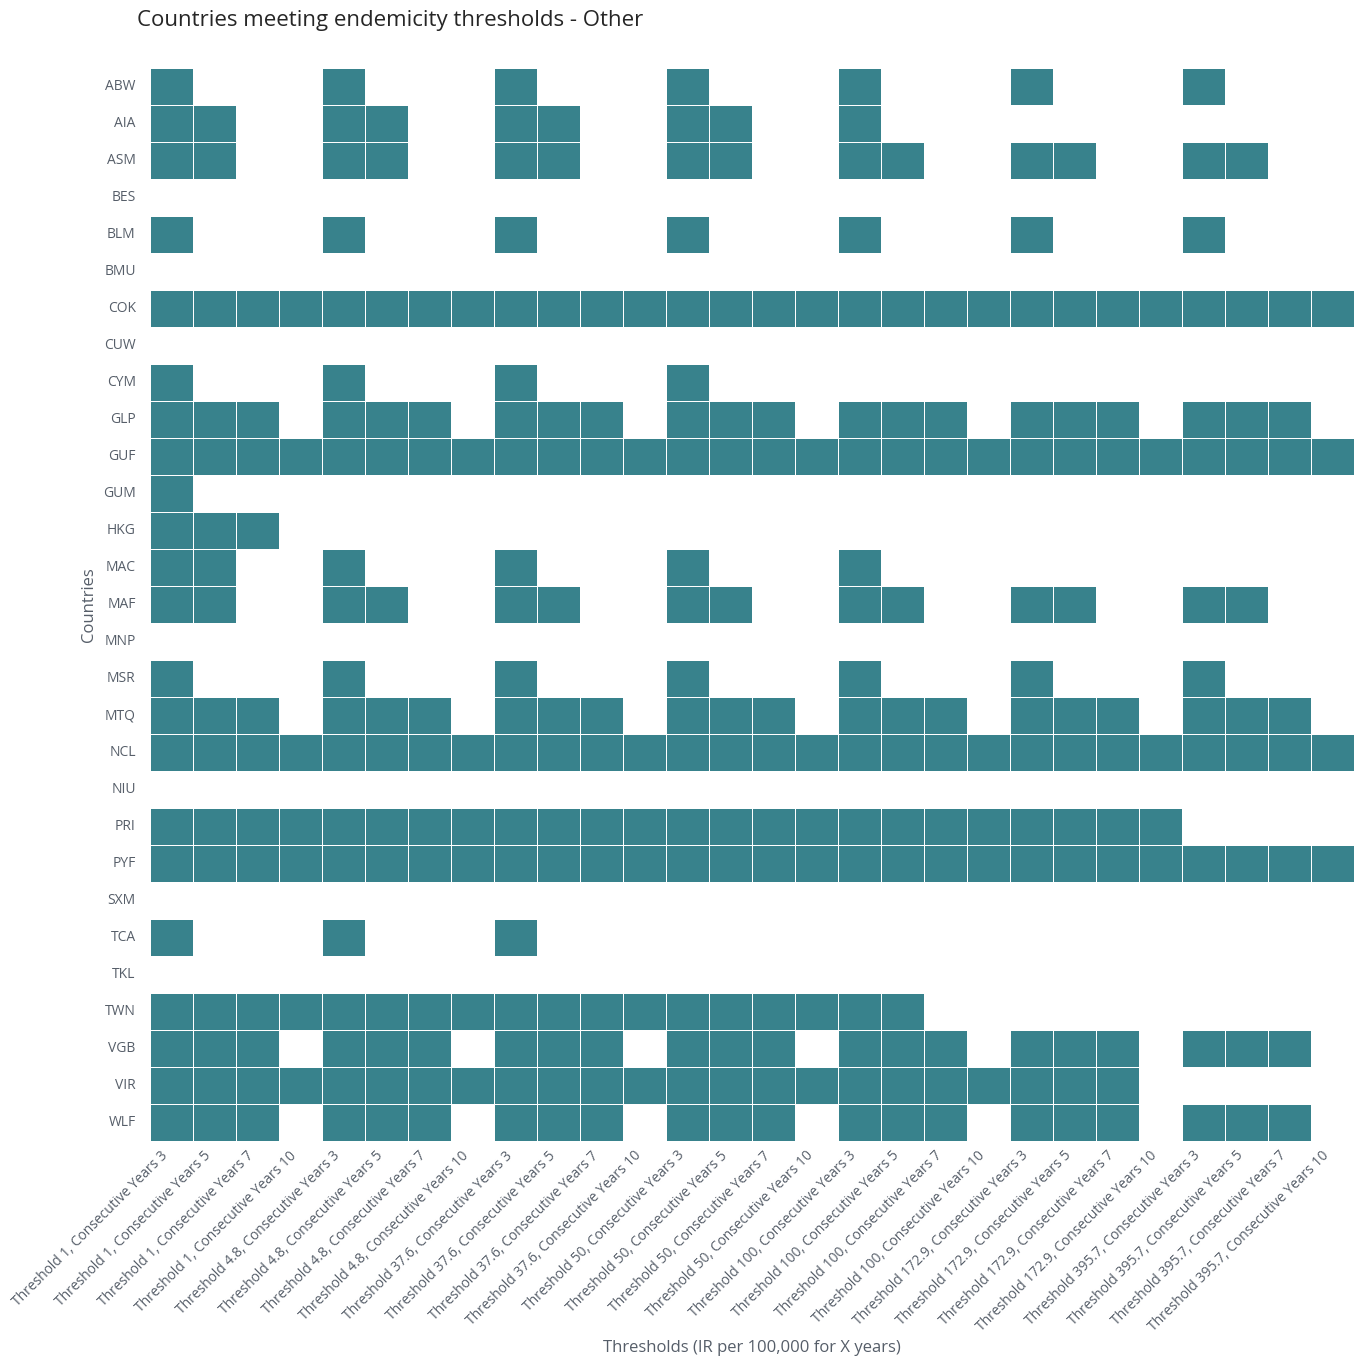

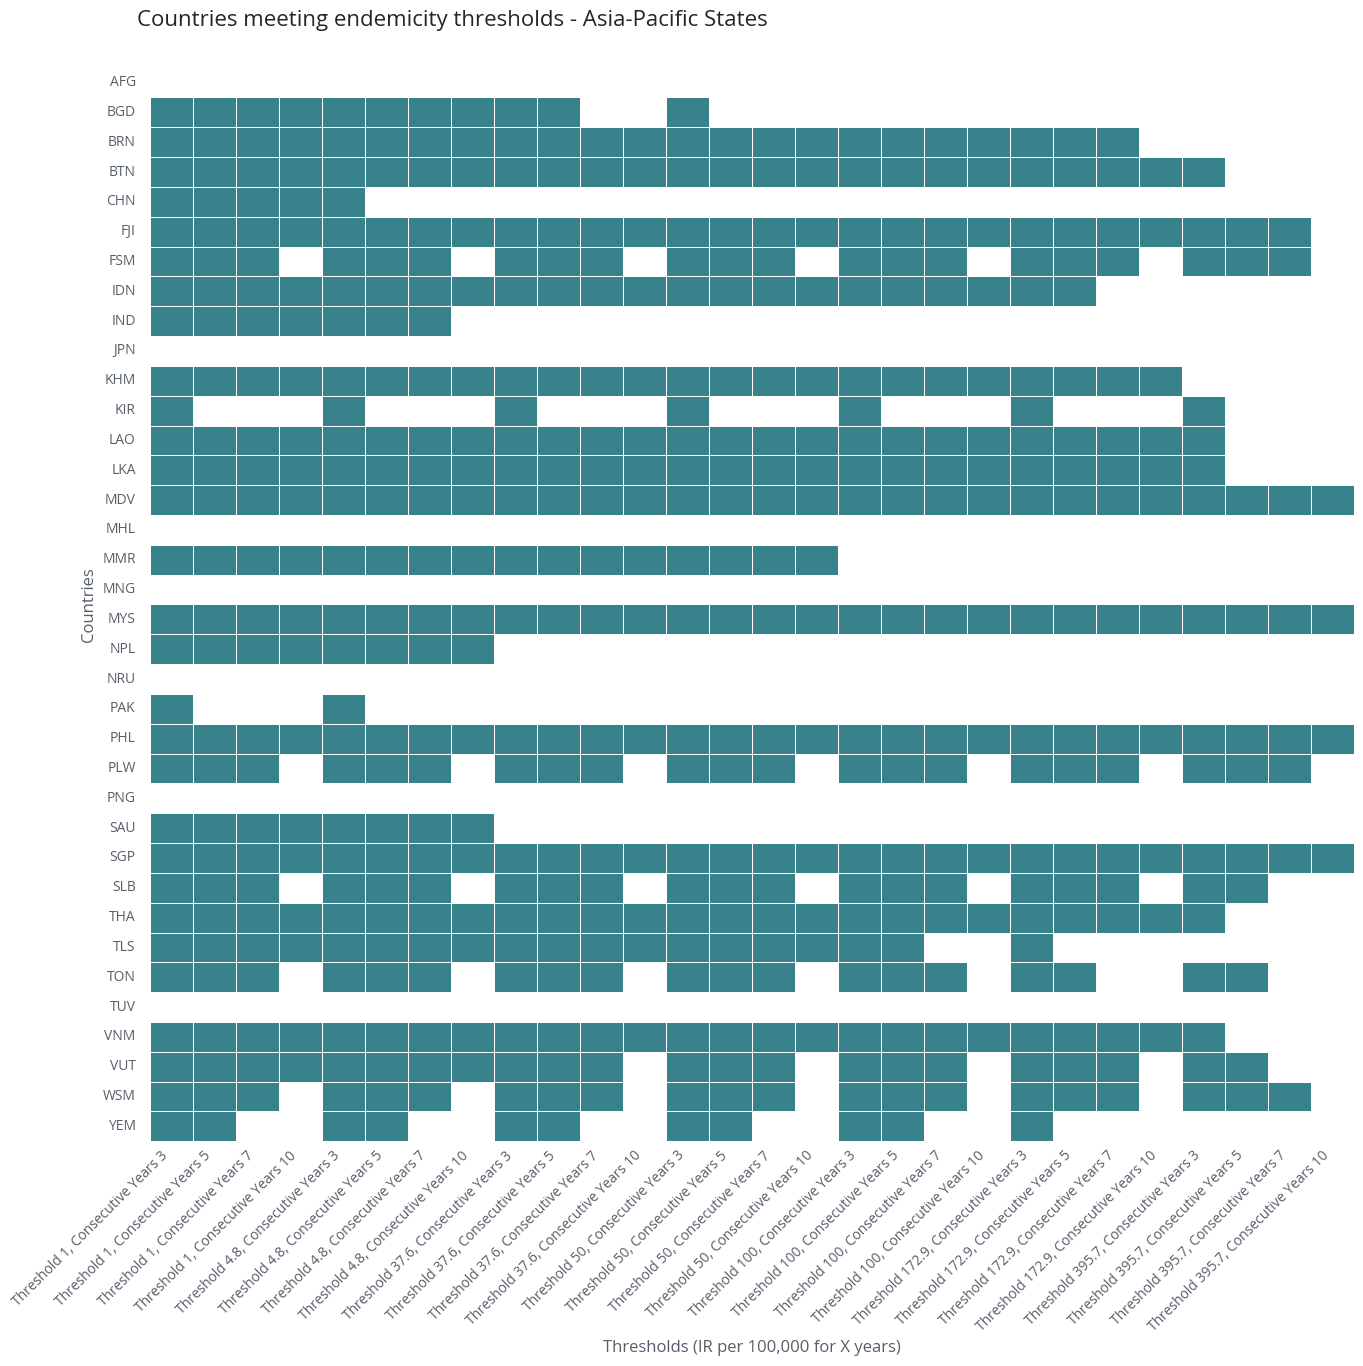

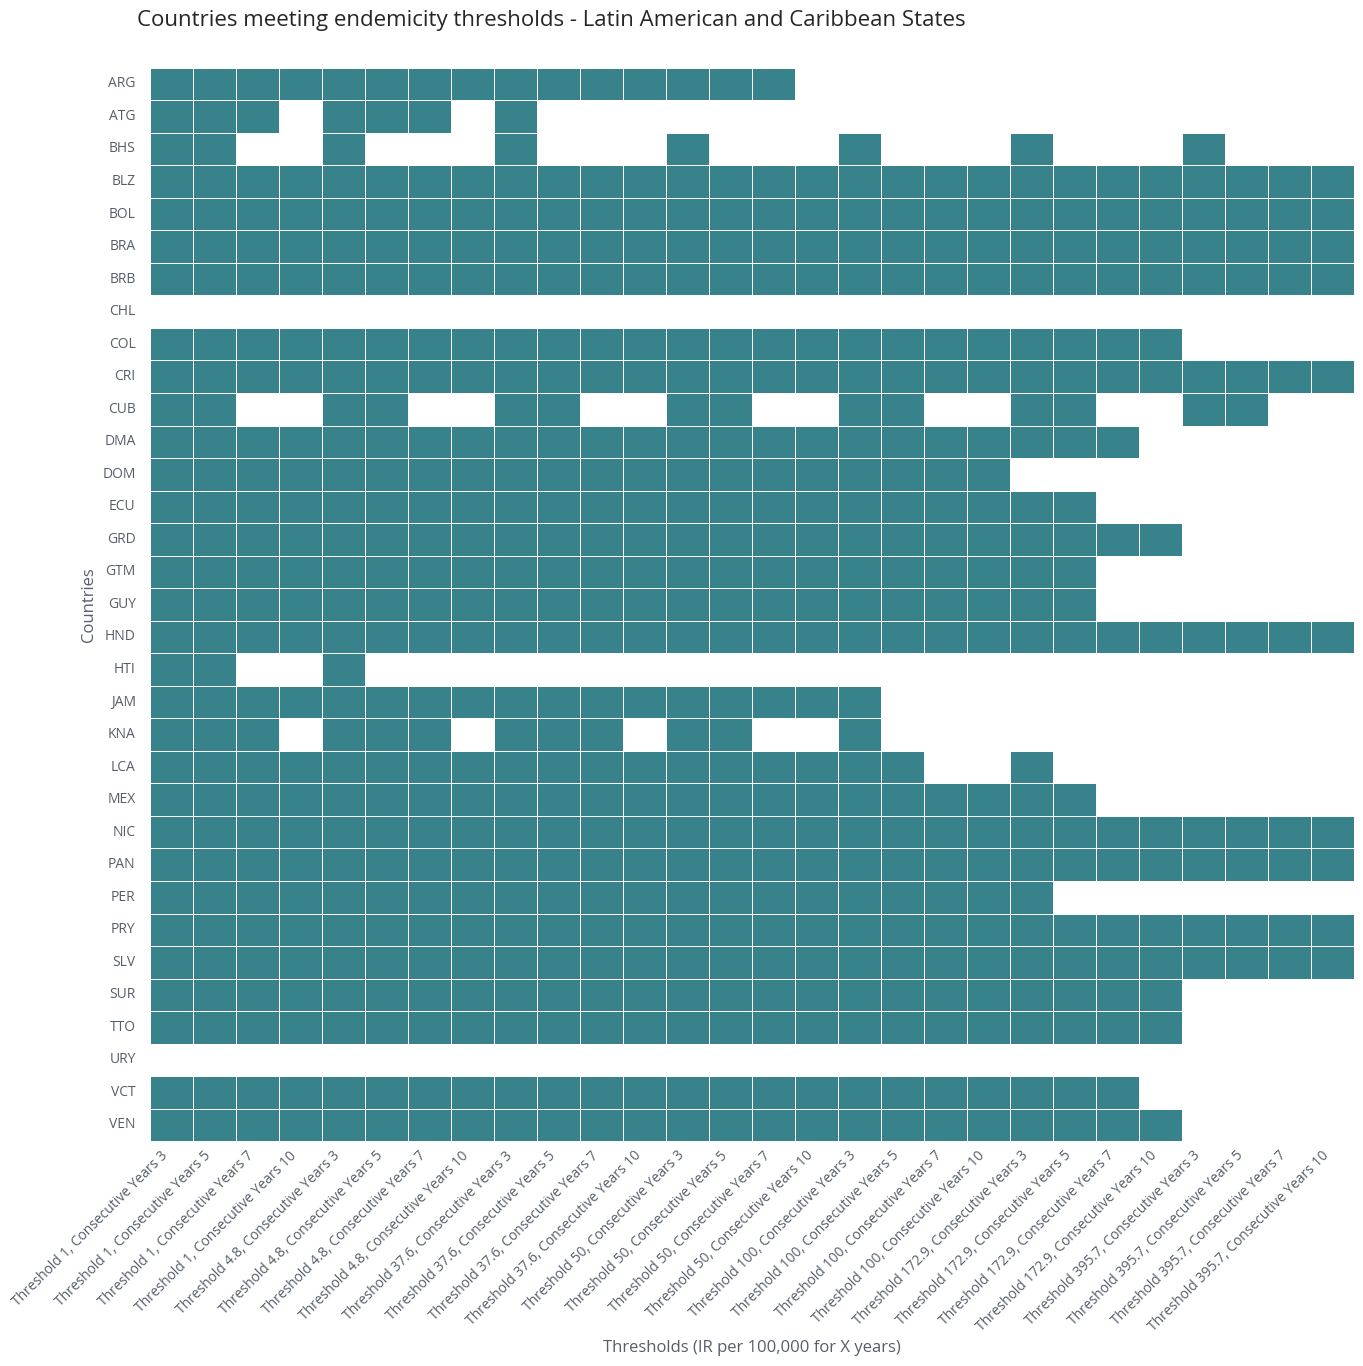

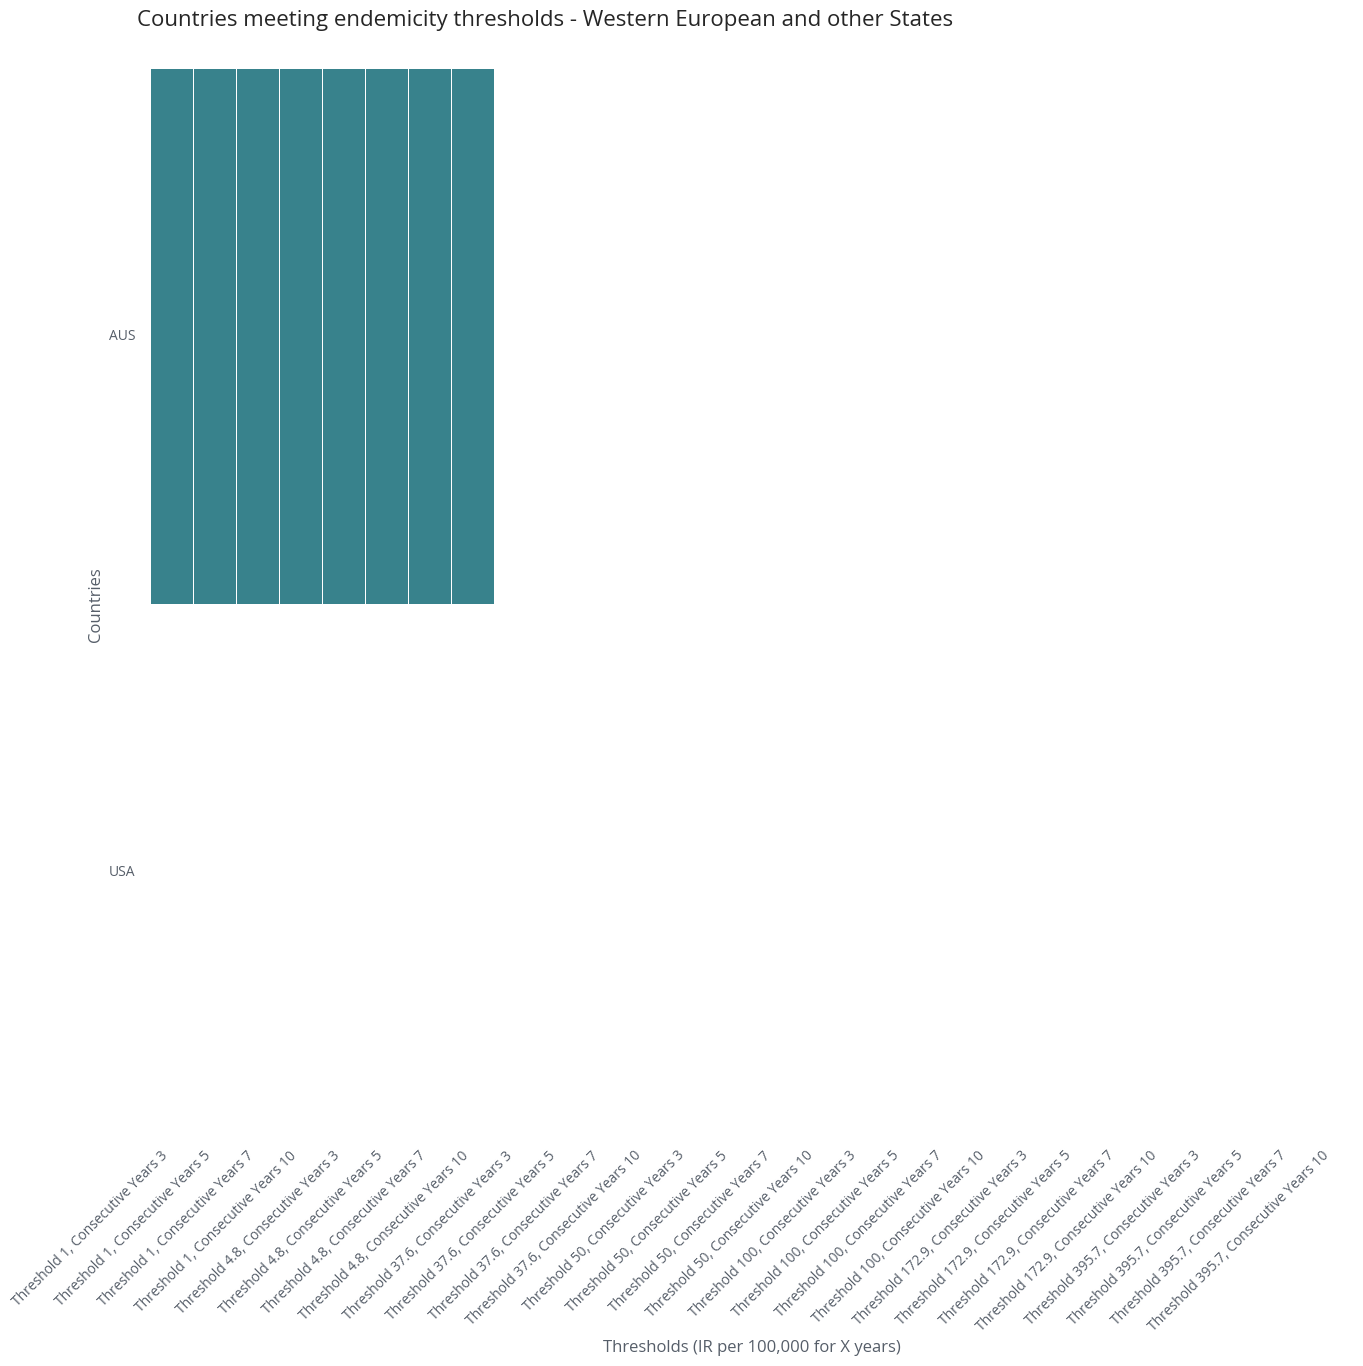

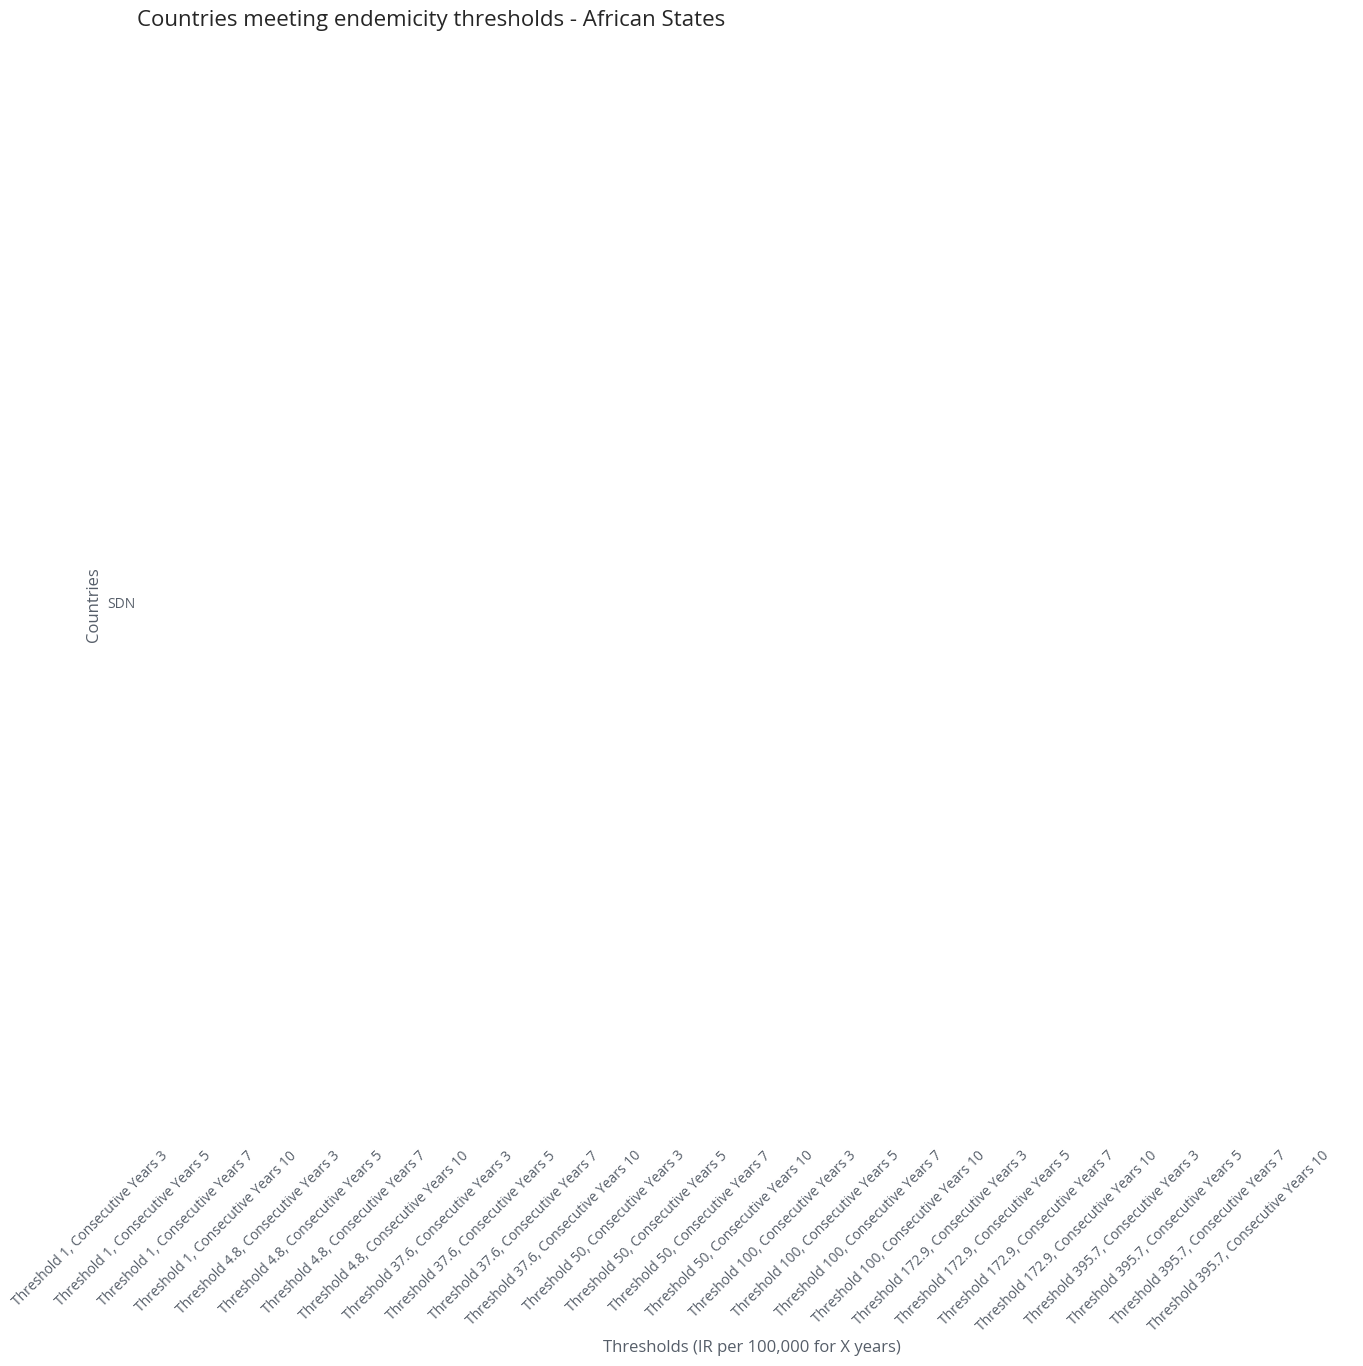

In [ ]:
# Custom color settings
custom_colors = ["white", colors[1]]  # Example colors (adjust as needed)

# Loop through each region and create a separate heatmap plot
for region in any_dengue['region_un'].unique():
    # Filter the data for the current region
    region_data = any_dengue[any_dengue['region_un'] == region]
    
    # Initialize the heatmap DataFrame for this region
    heatmap_data = pd.DataFrame(index=region_data['adm_0_iso3'].unique())  # Countries are the index
    
    # Add columns for each threshold and consecutive years combination
    for key, countries in endemic_countries_results.items():
        column_name = key  # This is the "Threshold X, Years Y" string
        # For each column, mark a '1' if the country is in the list, else '0'
        heatmap_data[column_name] = heatmap_data.index.isin(countries).astype(int)
    
    # Create a new plot for each region
    fig, ax = plt.subplots(figsize=(14, 14))  # Adjust size as needed
    sns.heatmap(heatmap_data, cmap=custom_colors, cbar=False, linewidths=0.5)

    # Add titles and labels
    plt.title(f'Countries meeting endemicity thresholds - {region}', fontsize=16, loc='left', x=-0.01)
    plt.xlabel('Thresholds (IR per 100,000 for X years)', fontsize=12)
    plt.ylabel('Countries (ever reported)', fontsize=12)

    # Set tick parameters
    ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=0)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.tick_params(axis='y', pad=10, width=30, labelsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0)

    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

    # Hide spines
    ax.spines.bottom.set_visible(False)
    ax.spines.left.set_visible(False)

    # Adjust layout for better fitting
    plt.tight_layout()

    # # Save the heatmap with the region name
    filename = f"../output/figures/open_dengue_threshold_heatmap_{region}.png"
    plt.savefig(filename, format='png', dpi=300)
    plt.close()

## Geocode

In [9]:
# # GEOCODE places (if needed)
#  user_agent = os.getenv("USER_AGENT")
# geolocator = Nominatim(user_agent=user_agent, timeout=10)

# # Load previously saved geocoded locations to avoid duplicates
# try:
#     with open('../data/cached_locations.pkl', 'rb') as f:
#         cached_locations = pickle.load(f)
# except (FileNotFoundError, EOFError):
#     cached_locations = {}

# def geocode_location(loc):
#     """Geocode the address if not already cached."""
#     if loc in cached_locations:
#         return cached_locations[loc]
#     else:
#         try:
#             location = geolocator.geocode(loc)
#             if location:
#                 # Only return latitude and longitude
#                 lat = location.latitude
#                 long = location.longitude
#                 lat_long = lat, long
#                 cached_locations[loc] = {
#                                     'latitude': lat,
#                                     'longitude': long,
#                                     'lat_long': lat_long
#                 }
#             else:
#                 cached_locations[loc] = None
#             # Save the cache after every new entry
#             with open('cached_locations.pkl', 'wb') as f:
#                 pickle.dump(cached_locations, f)
#             return cached_locations[loc]
#         except Exception as e:
#             print(f"Error geocoding {loc}: {e}")
#             return None

# locs = open_dengue["combined_place"]

# open_dengue["latitude"] = None
# open_dengue["longitude"] = None
# open_dengue["lat_long"] = None


# # Delay between requests in seconds to avoid hitting the rate limit
# REQUEST_DELAY = 0

# # Geocode locations with rate limiting and caching
# for idx, loc in enumerate(locs):
#     coords = geocode_location(loc)
    
#     if coords:
#         open_dengue.at[idx, "latitude"] = coords['latitude']
#         open_dengue.at[idx, "longitude"] = coords['longitude']
#         open_dengue.at[idx, "lat_long"] = coords['lat_long']
#         print(f"Address: {loc}, Coordinates: {coords}")
#     else:
#         print(f"Address: {loc}, Coordinates: Not found")
    
#     # Introduce delay to avoid API rate limits
#     time.sleep(REQUEST_DELAY)